In [343]:
%matplotlib inline

In [465]:
import numpy as np
import pandas as pd
import networkx as nx
import json
from collections import defaultdict
import random
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import sklearn.ensemble as ensemble
import vk
import copy
import pickle

In [420]:
def nx_graph(vk_graph):
    friends_graph = nx.Graph()
    for uid in vk_graph.keys():
        for friend in vk_graph[uid]:
            friends_graph.add_edge(str(uid), str(friend))
    return friends_graph

def parse_line(line):
    user_id, graph_str, friends_info, non_friends_info = line.rstrip("\n").split("\t")
    graph_json = json.loads(graph_str)
    friends_graph = nx_graph(graph_json)
    return user_id, friends_graph, json.loads(friends_info), json.loads(non_friends_info)

In [434]:
def jaccard(x, y):
    return len(x.intersection(y))/len(x.union(y))
    
def graph_features(G, center):
    JACCARD_FRIENDS = 10 
    center_friends = set(G.neighbors(center))
    friend_jaccard = {}
    for friend in center_friends:
        friend_jaccard[friend] =jaccard(set(G.neighbors(friend)), center_friends)
    result = {}
    result['nodes'] = defaultdict(lambda:{})
    for node in G.nodes():
        common_friends = list((set(G.neighbors(node)).intersection(center_friends)))
        common_friends.sort(key=lambda x: friend_jaccard[x], reverse=True)
        result['nodes'][node]['common_friends'] = len(common_friends)/len(center_friends)
        cnt = 0
        for friend in common_friends[:JACCARD_FRIENDS]:
            result['nodes'][node]['jaccard_%s' % cnt] = friend_jaccard[friend]
            cnt += 1

    return result

In [271]:
def get_dataset():
    cnt = 0
    result = []
    for line in open('trainset'):
        user, graph, friends_info, non_friends_info = parse_line(line)
        if (friends_info == {}) or (non_friends_info == {}):
            continue
        cnt += 1
        if(random.randint(0, 1)):
            potential_friend = random.choice(list(friends_info.keys()))
            features = graph_features(graph,user)['nodes'][potential_friend]
            features['target'] = 1
        else:
            potential_friend = random.choice(list(non_friends_info.keys()))
            features = graph_features(graph,user)['nodes'][potential_friend]
            features['target'] = 0
        result.append(features)
        if cnt % 100 == 0:
            print(cnt)
    return pd.DataFrame(result).fillna(0.0)

In [272]:
data = get_dataset()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


In [ ]:
target = data['target']
del(data['target'])

In [407]:
data_new = copy.deepcopy(data)

In [408]:
train_data, test_data, train_label, test_label = train_test_split(data_new, target)

In [451]:
clf = ensemble.GradientBoostingClassifier(n_estimators=100)
clf.fit(train_data, train_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [452]:
prediction = clf.predict_proba(test_data)

In [453]:
fpr, tpr, trsh = roc_curve(test_label, prediction[:,1])
roc_auc_score(test_label, prediction[:,1])

0.94894498690164331

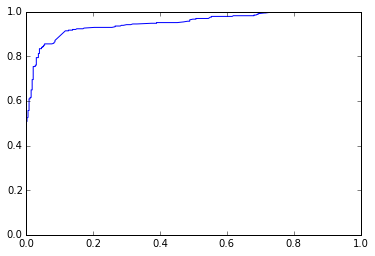

In [454]:
plt.plot(fpr, tpr)

In [455]:
def recommend_friends(user_id):
    graph_vk, nodes = vk.get_social_ball(user_id,1)
    graph_vk = nx_graph(graph_vk)
    g_features = graph_features(graph_vk, str(user_id))
    user_friends = set(graph_vk.neighbors(str(user_id)))
    features = []
    nodes = []
    for node in set(graph_vk.nodes()) - user_friends:
        features.append(g_features['nodes'][node])
        nodes.append(node)
    return pd.DataFrame(features, index=nodes).fillna(0.0)

In [462]:
G = recommend_friends(64383208)

In [463]:
prediction = clf.predict_proba(G)
res = {}
for i in range(len(G.index)):
    res[G.index[i]]=prediction[i][1]

In [467]:
clf_file = open('clf.pickle', 'wb')

In [469]:
pickle.dump(clf, clf_file)